🔄 Đang load dữ liệu...
Phân bố lớp: [14000. 14000. 14000. 14000. 14000. 14000. 13999. 14000. 14000. 14000.
 14000.]
✅ Dữ liệu đã được load. Bắt đầu xây dựng mô hình LSTM...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 35, 64)            16896     
                                                                 
 batch_normalization (BatchN  (None, 35, 64)           256       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 35, 128)           98816     
                                                                 
 batch_normalization_1 (Batc  (None, 35, 128)          512       
 hNormalization)                                                 
                                                                 
 lstm_2 (LSTM) 

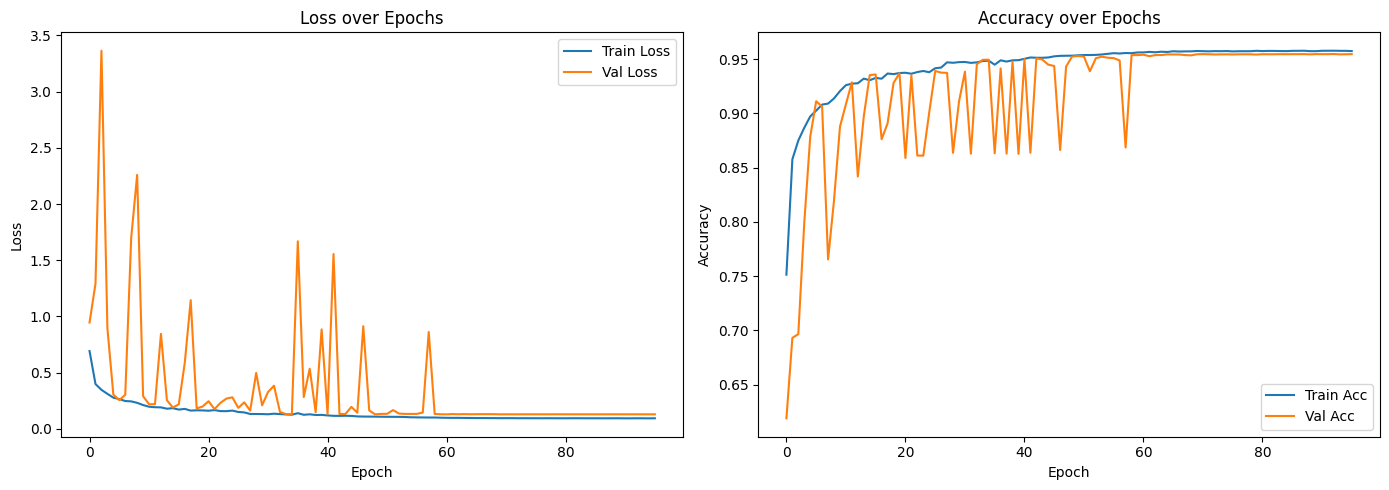

🔎 Dự đoán trên tập test...
172/172 [==============================] - 2s 7ms/step
📊 Ma trận nhầm lẫn:


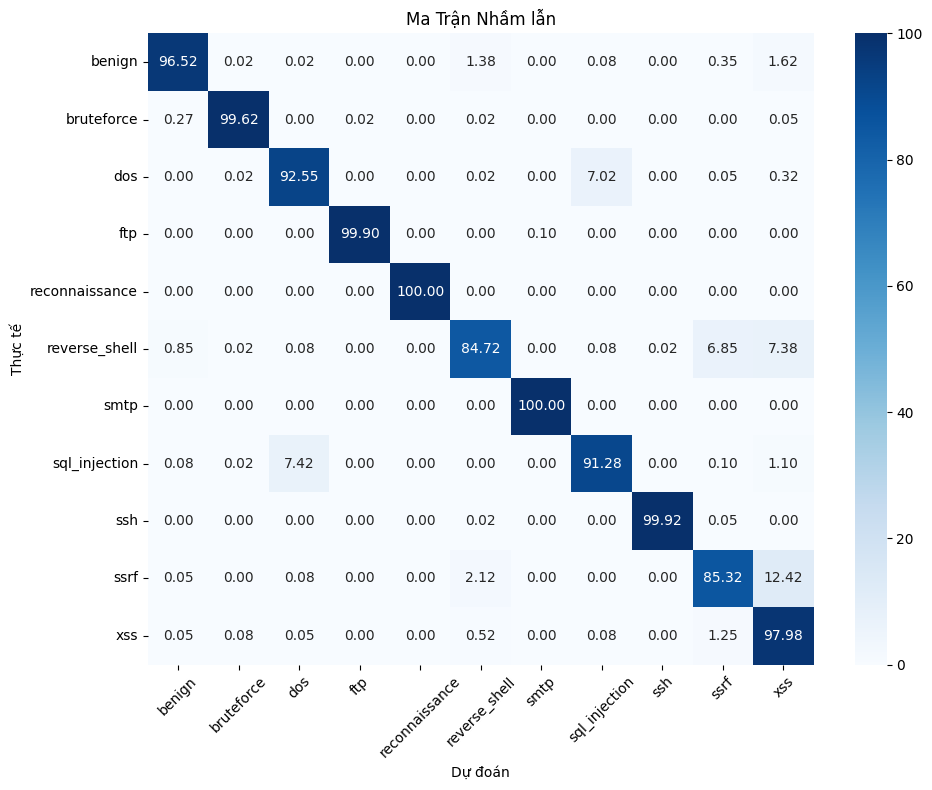


📋 Classification Report:
                precision    recall  f1-score   support

        benign     0.9867    0.9653    0.9759      4000
    bruteforce     0.9982    0.9962    0.9972      4000
           dos     0.9237    0.9255    0.9246      4000
           ftp     0.9997    0.9990    0.9994      4000
reconnaissance     1.0000    1.0000    1.0000      4000
 reverse_shell     0.9538    0.8472    0.8974      4000
          smtp     0.9990    1.0000    0.9995      4001
 sql_injection     0.9264    0.9127    0.9195      4000
           ssh     0.9997    0.9992    0.9995      4000
          ssrf     0.9080    0.8532    0.8798      4000
           xss     0.8105    0.9798    0.8872      4000

      accuracy                         0.9526     44001
     macro avg     0.9551    0.9526    0.9527     44001
  weighted avg     0.9551    0.9526    0.9527     44001


📈 ROC-AUC từng lớp:
Class benign - AUC: 0.9989
Class bruteforce - AUC: 0.9997
Class dos - AUC: 0.9977
Class ftp - AUC: 1.0000
Clas

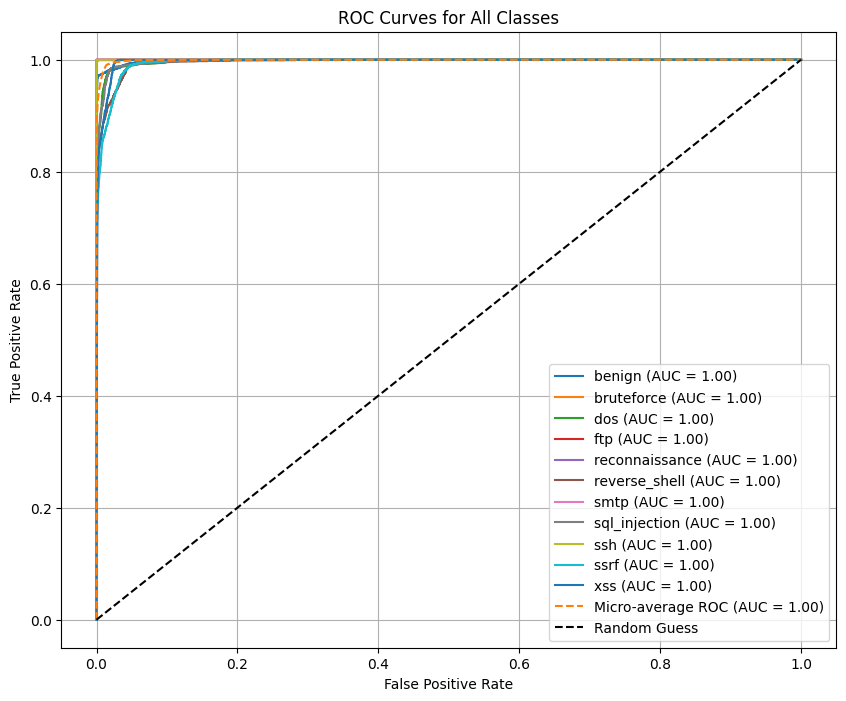


📊 F1-Score từng lớp:


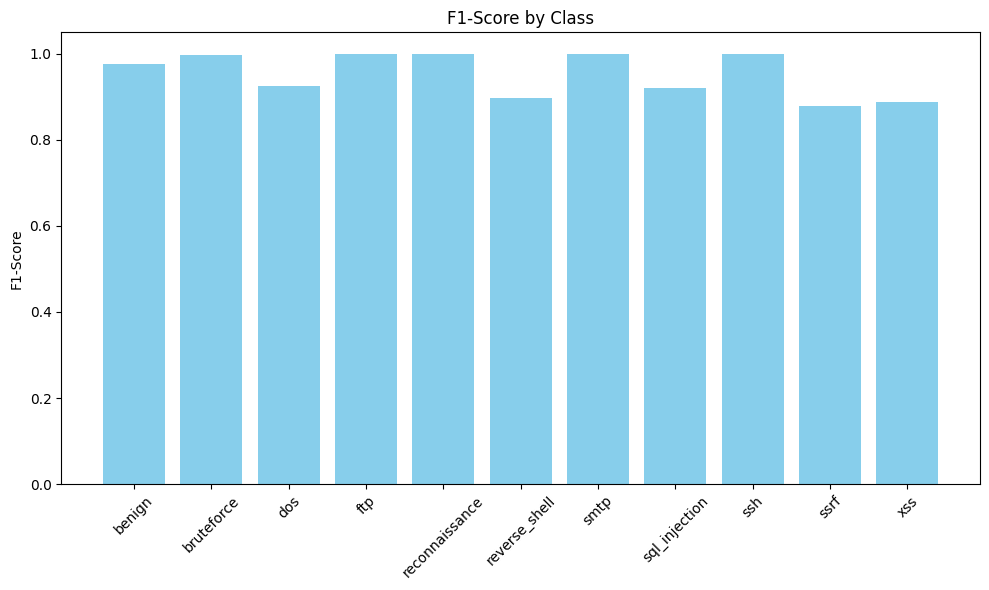


✅ Test Accuracy: 0.9526 - Test Loss: 0.1310
💾 Mô hình đã được lưu vào: lstm_webids23_model.h5


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# ==== 1. Tên lớp gộp ====
class_names = [
    'benign', 'bruteforce', 'dos', 'ftp', 'reconnaissance',
    'reverse_shell', 'smtp', 'sql_injection', 'ssh', 'ssrf', 'xss'
]

# ==== 2. Hàm reshape an toàn ====
def safe_reshape(X, n_features=35):
    if len(X.shape) == 1:
        assert X.size % n_features == 0, "Tổng phần tử không chia hết cho số đặc trưng"
        X = X.reshape(-1, n_features)
    elif X.shape[1] != n_features:
        raise ValueError(f"Số đặc trưng không đúng. Mong đợi {n_features}, nhưng nhận được {X.shape[1]}")
    return X.reshape(-1, n_features, 1)

# ==== 3. Load và xử lý dữ liệu ====
def load_data(data_path):
    X_train = np.load(os.path.join(data_path, 'X_train.npy'))
    y_train = np.load(os.path.join(data_path, 'y_train.npy'))
    X_val   = np.load(os.path.join(data_path, 'X_val.npy'))
    y_val   = np.load(os.path.join(data_path, 'y_val.npy'))
    X_test  = np.load(os.path.join(data_path, 'X_test.npy'))
    y_test  = np.load(os.path.join(data_path, 'y_test.npy'))

    # Kiểm tra NaN hoặc Inf
    def check_data(X, name="Data"):
        if np.any(np.isnan(X)) or np.any(np.isinf(X)):
            raise ValueError(f"{name} contains NaN or Inf values")
    check_data(X_train, "X_train")
    check_data(X_val, "X_val")
    check_data(X_test, "X_test")

    # Chuẩn hóa dữ liệu
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[1])).reshape(X_train.shape)
    X_val = scaler.transform(X_val.reshape(-1, X_val.shape[1])).reshape(X_val.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[1])).reshape(X_test.shape)

    X_train = safe_reshape(X_train, n_features=35)
    X_val   = safe_reshape(X_val, n_features=35)
    X_test  = safe_reshape(X_test, n_features=35)

    print("Phân bố lớp:", np.sum(y_train, axis=0))
    return X_train, y_train, X_val, y_val, X_test, y_test

# ==== 4. Xây dựng mô hình LSTM ====
def build_lstm_model(input_shape=(35, 1), num_classes=11):
    model = Sequential()
    # Tầng LSTM đầu tiên
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(BatchNormalization())
    
    # Tầng LSTM thứ hai
    model.add(LSTM(128, return_sequences=True))
    model.add(BatchNormalization())
    
    # Tầng LSTM thứ ba
    model.add(LSTM(256))
    model.add(BatchNormalization())
    
    # Tầng Dense
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=0.001), 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])
    return model

# ==== 5. Biểu đồ training ====
def plot_history(history):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

    plt.tight_layout()
    plt.show()

# ==== 6. Ma trận nhầm lẫn ====
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_percent = np.round(cm_percent * 100, 2)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.title('Ma Trận Nhầm lẫn')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ==== 7. ROC-AUC ====
def plot_roc_auc(y_true_onehot, y_pred_probs, class_names):
    """
    Vẽ biểu đồ ROC và tính AUC cho từng lớp và micro-average.
    Args:
        y_true_onehot (np.array): Ma trận one-hot của nhãn thực tế (n_samples, n_classes)
        y_pred_probs (np.array): Ma trận xác suất dự đoán (n_samples, n_classes)
        class_names (list): Danh sách tên các lớp
    """
    # Kiểm tra kích thước dữ liệu
    if y_true_onehot.shape != y_pred_probs.shape:
        raise ValueError("Kích thước của y_true_onehot và y_pred_probs không khớp: "
                         f"{y_true_onehot.shape} vs {y_pred_probs.shape}")

    n_classes = y_true_onehot.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Tính ROC và AUC cho từng lớp (One-vs-Rest)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        print(f"Class {class_names[i]} - AUC: {roc_auc[i]:.4f}")

    # Tính Micro-average ROC
    fpr_micro, tpr_micro, _ = roc_curve(y_true_onehot.ravel(), y_pred_probs.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    print(f"Micro-average ROC AUC: {roc_auc_micro:.4f}")

    # Tính Macro-average ROC (trung bình AUC của từng lớp)
    roc_auc_macro = np.mean(list(roc_auc.values()))
    print(f"Macro-average ROC AUC: {roc_auc_macro:.4f}")

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC (AUC = {roc_auc_micro:.2f})', linestyle='--')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.title("ROC Curves for All Classes")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return roc_auc, roc_auc_micro, roc_auc_macro

# ==== 8. Biểu đồ F1-score ====
def plot_f1_scores(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    f1_scores = [report[cls]['f1-score'] for cls in class_names]
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, f1_scores, color='skyblue')
    plt.xticks(rotation=45)
    plt.ylabel('F1-Score')
    plt.title('F1-Score by Class')
    plt.tight_layout()
    plt.show()

# ==== 9. Main pipeline ====
def main():
    data_path = r'D:/webids23_processed1/'
    print("🔄 Đang load dữ liệu...")
    X_train, y_train, X_val, y_val, X_test, y_test = load_data(data_path)

    print("✅ Dữ liệu đã được load. Bắt đầu xây dựng mô hình LSTM...")
    model = build_lstm_model()

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=35, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
        ModelCheckpoint('best_lstm_model.h5', save_best_only=True, monitor='val_accuracy')
    ]
    model.summary()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=300,
        batch_size=128,
        callbacks=callbacks,
        verbose=1
    )

    print("✅ Huấn luyện xong. Hiển thị biểu đồ...")
    plot_history(history)

    print("🔎 Dự đoán trên tập test...")
    y_pred_probs = model.predict(X_test, batch_size=256)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print("📊 Ma trận nhầm lẫn:")
    plot_confusion_matrix(y_true, y_pred, class_names)

    print("\n📋 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    print("\n📈 ROC-AUC từng lớp:")
    roc_auc_dict, roc_auc_micro, roc_auc_macro = plot_roc_auc(y_test, y_pred_probs, class_names)
    print("\n📊 F1-Score từng lớp:")
    plot_f1_scores(y_true, y_pred, class_names)

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"\n✅ Test Accuracy: {test_acc:.4f} - Test Loss: {test_loss:.4f}")

    model.save("lstm_webids23_model.h5")
    print("💾 Mô hình đã được lưu vào: lstm_webids23_model.h5")

# ==== 10. Chạy chương trình ====
if __name__ == "__main__":
    main()